In [1]:
#!/usr/bin/python
#dbr 7/17/23
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.cm as cm
import seaborn as sns

sns.set_style("ticks")

#for mem
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [2]:
df=pd.read_csv('data/wideout.csv')#,index=False)

df.columns

Index(['Unnamed: 0', 'short_id', 'agemo_at_ART', 'f/m', 'ARTregimen',
       'time_ART_mo', 'log10VL', 'cens_vl', 'log10CD4', 'log10int',
       'cens_intact', 'log10def', 'log10ratio'],
      dtype='object')

In [3]:
len(df['short_id'].unique())

55

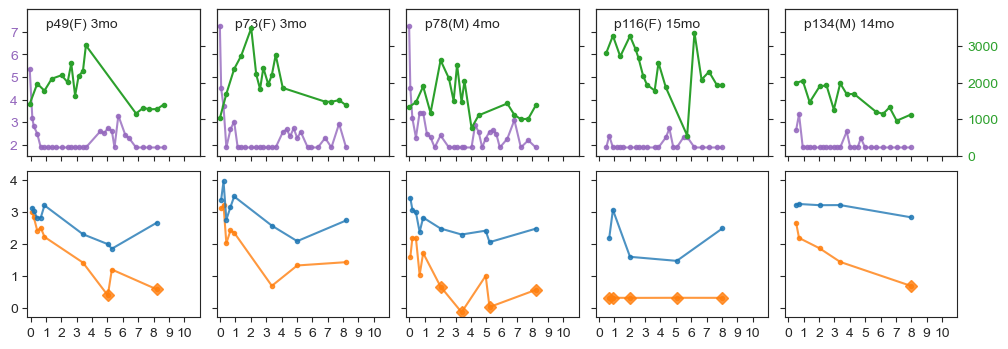

In [4]:
#plot 5 individual curves for TCR participants

fig, axs = plt.subplots(2,5,sharex=True,figsize=(12,4))
for i,p in enumerate([49,73,78,116,134]):
#for p in df['short_id'].unique():
    tdf=df[df['short_id']==p]
    
    tdf1=tdf[['time_ART_mo','log10VL']].dropna()
    tdf2=tdf[['time_ART_mo','log10CD4']].dropna()
    tdf3=tdf[['time_ART_mo','log10int','log10def','cens_intact']].dropna()

    #extra info
    mf=['F','M'][int(tdf['f/m'].iloc[0])]
    age = tdf['agemo_at_ART'].iloc[0]

    ax1=axs[0][i]
    ax1.plot(tdf1['time_ART_mo']/12,tdf1['log10VL'],marker='.',alpha=0.8,color='tab:purple')#,label='all')
    ax1.annotate('p'+str(int(p))+'('+mf+') '+str(int(age))+'mo',[1,7.2])
    ax1.set_ylim([1.5,8])
    ax1.tick_params(axis='y', labelcolor='tab:purple')
    ax1.set_yticks([2,3,4,5,6,7])
    if i>0:
        ax1.set_yticklabels([])

    ax2 = ax1.twinx() # Create a second y-axis sharing the same x-axis
    ax2.plot(tdf2['time_ART_mo']/12,10**tdf2['log10CD4'],marker='.', color='tab:green')
    ax2.set_ylim([0,4000])
    ax2.set_yticks([0,1000,2000,3000])
    if i<4:
        ax2.set_yticklabels([])
    ax2.tick_params(axis='y', labelcolor='tab:green')

    ax3=axs[1][i]
    ax3.plot(tdf3['time_ART_mo'][tdf3['cens_intact']==1]/12,tdf3['log10int'][tdf3['cens_intact']==1].values,marker='D',ls='',alpha=0.8,color='tab:orange',label='Censored')
    ax3.plot(tdf3['time_ART_mo']/12,tdf3['log10int'].values,marker='.',alpha=0.8,color='tab:orange',label='Intact')
    ax3.plot(tdf3['time_ART_mo']/12,tdf3['log10def'].values,marker='.',alpha=0.8,color='tab:blue',label='Defective')
    ax3.set_ylim([-0.3,4.3])
    ax3.set_yticks([0,1,2,3,4])
    if i>0:
        ax3.set_yticklabels([])
    
ax1.set_xlim([-0.2,11])
ax1.set_xticks(np.arange(0,11,1))
plt.subplots_adjust(hspace=0.1)
plt.subplots_adjust(wspace=0.1)
plt.savefig('figures/individuals-wTCR.pdf',dpi=600)


In [5]:
#models, take plist which are different lengths

def onephase(t,plist):
    y0,th = plist
    y = y0*np.exp(-th*t)
    return y

def twophase(t,plist):
    y01,th1,th2,tchg = plist
    y02 = y01*np.exp((-th1+th2)*tchg)
    y = y01*np.exp(-th1*t)+y02*np.exp(-th2*t)
    return y 

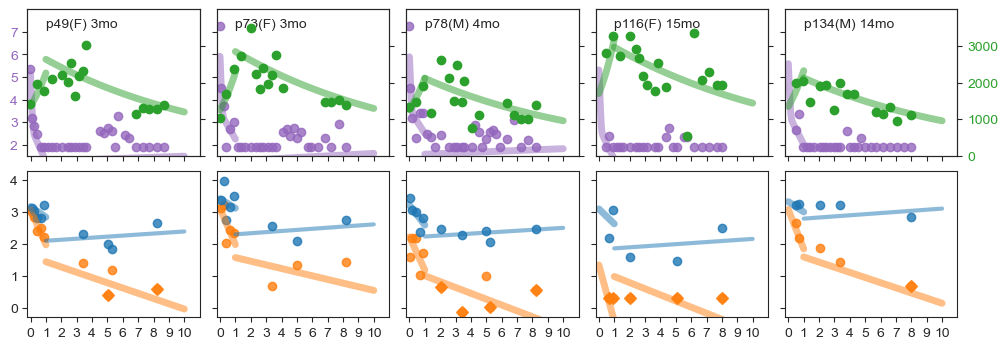

In [6]:
## WITH MODELS????

mz='o'
lz=''

tsim1=np.linspace(0,12,100)
tsim2=np.linspace(12,120,100)

fig, axs = plt.subplots(2,5,sharex=True,figsize=(12,4))
for i,p in enumerate([49,73,78,116,134]):
    tdf=df[df['short_id']==p]
    
    tdf1=tdf[['time_ART_mo','log10VL']].dropna()
    tdf2=tdf[['time_ART_mo','log10CD4']].dropna()
    tdf3=tdf[['time_ART_mo','log10int','log10def','cens_intact']].dropna()

    #extra info
    mf=['F','M'][int(tdf['f/m'].iloc[0])]
    age = tdf['agemo_at_ART'].iloc[0]

    ax1=axs[0][i]
    ax1.plot(tdf1['time_ART_mo']/12,tdf1['log10VL'],marker=mz,alpha=0.8,color='tab:purple',ls=lz)#,label='all')
    ax1.annotate('p'+str(int(p))+'('+mf+') '+str(int(age))+'mo',[1,7.2])
    ax1.set_ylim([1.5,8])
    ax1.tick_params(axis='y', labelcolor='tab:purple')
    ax1.set_yticks([2,3,4,5,6,7])
    if i>0:
        ax1.set_yticklabels([])

    ## simulation V
    param_df=pd.read_csv('monolix/splitV<1/IndividualParameters/estimatedIndividualParameters.txt')
    tdfp = param_df[param_df['id']==p]
    V01,thV1,thV2,tchg = tdfp[['V1_0_mode', 'thV1_mode', 'thV2_mode', 'tchg_mode']].values[0]
    lV = np.log10(twophase(tsim1,(V01,thV1,thV2,tchg)))
    ax1.plot(tsim1/12,lV,color='tab:purple',lw=5,alpha=0.5)
    
    param_df=pd.read_csv('monolix/splitV>1/IndividualParameters/estimatedIndividualParameters.txt')
    tdfp = param_df[param_df['id']==p]
    V01,thV1 = tdfp[['V1_0_mode', 'thV1_mode']].values[0]
    lV = np.log10(onephase(tsim2-tsim2[0],(V01,thV1)))
    ax1.plot(tsim2/12,lV,color='tab:purple',lw=5,alpha=0.5)
    
    #data S
    ax2 = ax1.twinx() # Create a second y-axis sharing the same x-axis
    ax2.plot(tdf2['time_ART_mo']/12,10**tdf2['log10CD4'],marker=mz, color='tab:green',ls=lz)
    ax2.set_ylim([0,4000])
    ax2.set_yticks([0,1000,2000,3000])
    if i<4:
        ax2.set_yticklabels([])
    ax2.tick_params(axis='y', labelcolor='tab:green')

    #simulation S
    param_df=pd.read_csv('monolix/splitS<1/IndividualParameters/estimatedIndividualParameters.txt')
    tdfp = param_df[param_df['id']==p]
    V01,thV1 = tdfp[['V1_0_mode', 'thV1_mode']].values[0]
    S = onephase(tsim1,(V01,thV1))
    ax2.plot(tsim1/12,S,color='tab:green',lw=5,alpha=0.5)
    
    param_df=pd.read_csv('monolix/splitS>1/IndividualParameters/estimatedIndividualParameters.txt')
    tdfp = param_df[param_df['id']==p]
    V01,thV1 = tdfp[['V1_0_mode', 'thV1_mode']].values[0]
    S = onephase(tsim2-tsim2[0],(V01,thV1))
    ax2.plot(tsim2/12,S,color='tab:green',lw=5,alpha=0.5)

    ax3=axs[1][i]
    ax3.plot(tdf3['time_ART_mo'][tdf3['cens_intact']==1]/12,tdf3['log10int'][tdf3['cens_intact']==1].values,marker='D',ls='',alpha=0.8,color='tab:orange',label='Censored')
    ax3.plot(tdf3['time_ART_mo']/12,tdf3['log10int'].values,marker=mz,alpha=0.8,color='tab:orange',label='Intact',ls=lz)
    ax3.plot(tdf3['time_ART_mo']/12,tdf3['log10def'].values,marker=mz,alpha=0.8,color='tab:blue',label='Defective',ls=lz)
    ax3.set_ylim([-0.3,4.3])
    ax3.set_yticks([0,1,2,3,4])
    if i>0:
        ax3.set_yticklabels([])
    
    #simulation I
    param_df=pd.read_csv('monolix/splitI<1/IndividualParameters/estimatedIndividualParameters.txt')
    tdfp = param_df[param_df['id']==p]
    V01,thV1 = tdfp[['V1_0_mode', 'thV1_mode']].values[0]
    I = np.log10(onephase(tsim1,(V01,thV1)))
    ax3.plot(tsim1/12,I,color='tab:orange',lw=5,alpha=0.5)
    
    param_df=pd.read_csv('monolix/splitI>1/IndividualParameters/estimatedIndividualParameters.txt')
    tdfp = param_df[param_df['id']==p]
    V01,thV1 = tdfp[['V1_0_mode', 'thV1_mode']].values[0]
    I = np.log10(onephase(tsim2-tsim2[0],(V01,thV1)))
    ax3.plot(tsim2/12,I,color='tab:orange',lw=5,alpha=0.5)

    #simulation D
    param_df=pd.read_csv('monolix/splitD<1/IndividualParameters/estimatedIndividualParameters.txt')
    tdfp = param_df[param_df['id']==p]
    V01,thV1 = tdfp[['V1_0_mode', 'thV1_mode']].values[0]
    I = np.log10(onephase(tsim1,(V01,thV1)))
    ax3.plot(tsim1/12,I,color='tab:blue',lw=5,alpha=0.5)
    
    param_df=pd.read_csv('monolix/splitD>1/IndividualParameters/estimatedIndividualParameters.txt')
    tdfp = param_df[param_df['id']==p]
    V01,thV1 = tdfp[['V1_0_mode', 'thV1_mode']].values[0]
    I = np.log10(onephase(tsim2-tsim2[0],(V01,thV1)))
    ax3.plot(tsim2/12,I,color='tab:blue',lw=3,alpha=0.5)

    
ax1.set_xlim([-0.2,11])
ax1.set_xticks(np.arange(0,11,1))
plt.subplots_adjust(hspace=0.1)
plt.subplots_adjust(wspace=0.1)
plt.savefig('figures/individuals-wTCR.pdf',dpi=600)
